# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This notebook, describes how I built the Traffic sign Classifier.

---
## Step 0: Load The Data
At first we will need to load the data from the pickle files.

In [1]:
# Load pickled data
import pickle

training_file = "data/train.p"
validation_file="data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.


### A Basic Summary of the Data Set

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

Here i plot a grapth representing number of sample for each class.

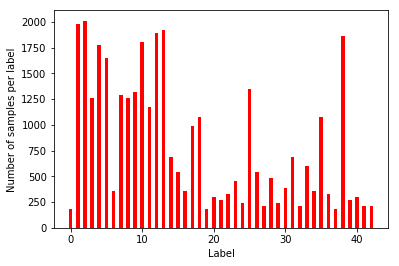

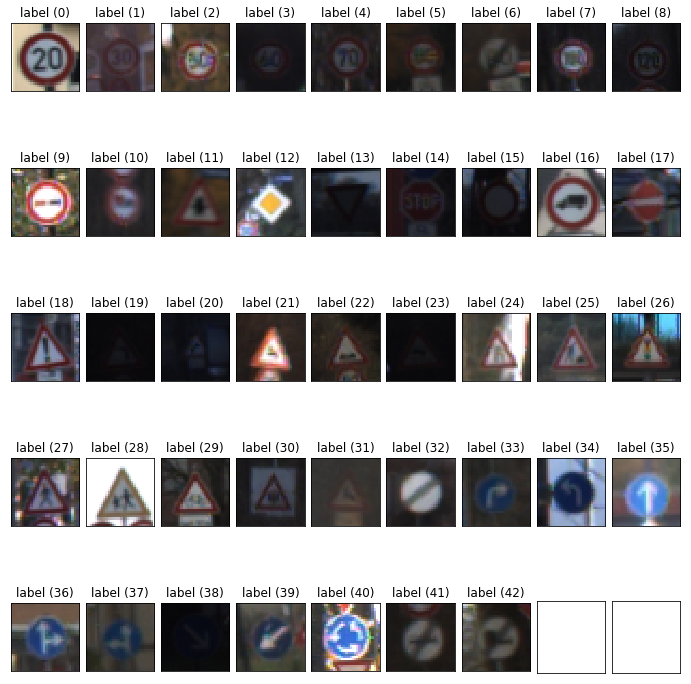

In [3]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

fig, ax = plt.subplots()
x,indexs,y = np.unique(y_train,return_counts = True,return_index=True)
ax.bar(x, y, .5, color='r')
ax.set_xlabel('Label')
ax.set_ylabel('Number of samples per label')

# indexs = np.random.randint(0, len(X_train),18)

fig, axes = plt.subplots(5, 9, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=1, wspace=0.1)

for ax, index in zip(axes.flat, indexs):
    ax.imshow(X_train[index])
    ax.set_title("label ({})".format(y_train[index]))

plt.show()



----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

The first step I have done is to convert my images into gray scale to reduce the network's complexity by having only one color channel. Then I applied a Histogram Equalization as we have some dark images in our data set.

Finally, the image data should be normalized so that the data has mean zero and equal variance.


In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import cv2

In [5]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    return (a + (image_data)*(b - a)/255)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def preprocess_data(data):
    preprocessed_data = []
    for image in data:
        image = grayscale(image)
        image = cv2.equalizeHist(image)
        image = normalize_grayscale(image)
        preprocessed_data.append(image)
    return preprocessed_data

In [6]:
X_train = preprocess_data(X_train)
X_valid = preprocess_data(X_valid)
X_test = preprocess_data(X_test)

Now let's have another look on the same sample images after preprocessing

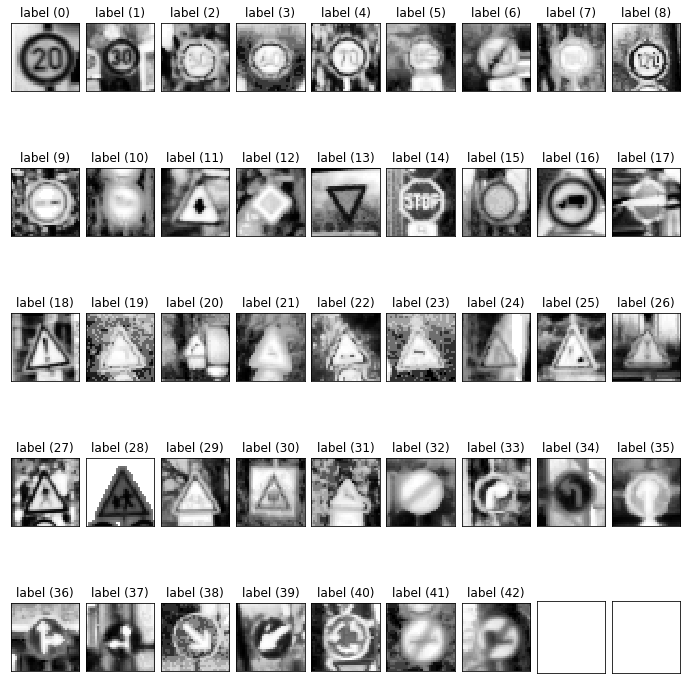

In [7]:
fig, axes = plt.subplots(5, 9, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=1, wspace=0.1)

for ax, index in zip(axes.flat, indexs):
    ax.imshow(X_train[index],cmap='gray')
    ax.set_title("label ({})".format(y_train[index]))

### Model Architecture

Here I used the LeNet achitecture with some modification. Basically I added two dropout steps at the output of layers 3 and 4 to improve the network's performance.

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from numpy import array

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits,conv1,conv2

In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)
EPOCHS = 40
BATCH_SIZE = 128
rate = 0.001

In [10]:
logits,conv1,conv2 = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In the next step we will train the model and then save it.

#### Train the model

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    X_valid = np.expand_dims(X_valid, axis=3)
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x = np.expand_dims(batch_x, axis=3)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
            
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.567

EPOCH 2 ...
Validation Accuracy = 0.778

EPOCH 3 ...
Validation Accuracy = 0.834

EPOCH 4 ...
Validation Accuracy = 0.859

EPOCH 5 ...
Validation Accuracy = 0.868

EPOCH 6 ...
Validation Accuracy = 0.901

EPOCH 7 ...
Validation Accuracy = 0.913

EPOCH 8 ...
Validation Accuracy = 0.918

EPOCH 9 ...
Validation Accuracy = 0.928

EPOCH 10 ...
Validation Accuracy = 0.928

EPOCH 11 ...
Validation Accuracy = 0.933

EPOCH 12 ...
Validation Accuracy = 0.931

EPOCH 13 ...
Validation Accuracy = 0.940

EPOCH 14 ...
Validation Accuracy = 0.946

EPOCH 15 ...
Validation Accuracy = 0.944

EPOCH 16 ...
Validation Accuracy = 0.944

EPOCH 17 ...
Validation Accuracy = 0.949

EPOCH 18 ...
Validation Accuracy = 0.949

EPOCH 19 ...
Validation Accuracy = 0.949

EPOCH 20 ...
Validation Accuracy = 0.945

EPOCH 21 ...
Validation Accuracy = 0.953

EPOCH 22 ...
Validation Accuracy = 0.957

EPOCH 23 ...
Validation Accuracy = 0.957

EPOCH 24 ...
Validation Accura

#### Evaluate the model

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    X_test = np.expand_dims(X_test, axis=3)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.931


---

## Step 3: Test a Model on New Images

Now let's try our model on 5 new images from the internet

### Load and Output the Images

In [14]:
from os import listdir
from os.path import isfile, join
import cv2

files = [f for f in listdir('images/') if isfile(join('images/', f))]

images = []
labels = []
for file in files:
    image = cv2.imread(join('images/', file),-1)
    label = file.split('_')[0]
    images.append(image)
    labels.append(label)
images = preprocess_data(images)

Now let's visualize the data

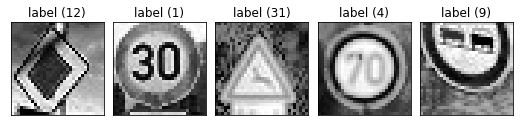

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(9, 9),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=2, wspace=0.1)

for ax, image,label in zip(axes.flat, images,labels):
    ax.imshow(image,cmap='gray')
    ax.set_title("label ({})".format(label))


### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from .\lenet


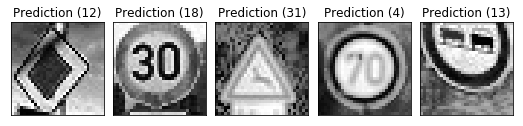

In [16]:
def getPrediction(X_data):
    num_examples = len(X_data)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        batch_x = np.expand_dims(X_data, axis=3)
        predictions = sess.run(logits, feed_dict={x: batch_x, keep_prob : 1})
        top_predictions = sess.run(tf.nn.top_k(predictions, k=5))
        predictions = sess.run(tf.argmax(predictions, 1))
    return predictions,top_predictions

predictions, top_predictions = getPrediction(images)


fig, axes = plt.subplots(1, 5, figsize=(9, 9),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=2, wspace=0.1)

for ax, image,label in zip(axes.flat, images,predictions):
    ax.imshow(image,cmap='gray')
    ax.set_title("Prediction ({})".format(label))

### Analyze Performance

In [17]:
### Calculate the accuracy for these 5 new images. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    batch_x = np.expand_dims(images, axis=3)
    test_accuracy = evaluate(batch_x, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.600


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, we print out the model's softmax probabilities to show the **certainty** of the model's predictions

In [18]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
print(top_predictions)

TopKV2(values=array([[ 37.08348465,   1.05275941,  -5.20464945,  -9.34842491,
        -11.75564194],
       [  6.71199036,   3.33718348,   3.07043242,   1.51997912,
          0.58827156],
       [ 17.54683304,  12.52876759,   4.20278883,   3.61728024,
          2.95892763],
       [ 25.49307632,  11.82583618,  10.5564394 ,   2.01921844,
          1.34329176],
       [ 15.0106287 ,   6.58296251,   1.84210634,   1.3458631 ,
         -0.71231902]], dtype=float32), indices=array([[12, 13, 40, 42, 35],
       [18, 40, 27, 37, 26],
       [31, 21, 29, 23, 19],
       [ 4,  8, 15,  7, 39],
       [13, 12, 35,  9, 10]]))


---

## Step 4 : Visualize the Neural Network's State with Test Images

 We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training our neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.


In [19]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        image_extended = np.expand_dims(image_input, axis=0)
        image_extended = np.expand_dims(image_extended, axis=3)
        activation = tf_activation.eval(session=sess,feed_dict={x : image_extended})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from .\lenet


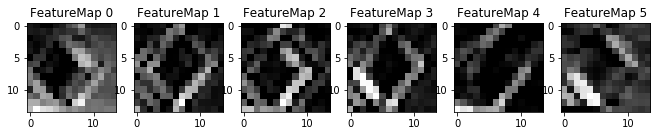

In [20]:
outputFeatureMap(images[0],conv1)

INFO:tensorflow:Restoring parameters from .\lenet


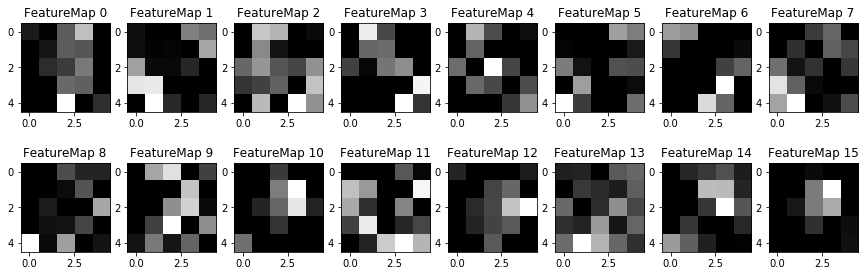

In [21]:
outputFeatureMap(images[0],conv2)